In [0]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import LeakyReLU, ELU
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers.core import Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.callbacks import TensorBoard
import numpy as np
import os
from keras import optimizers
import math
import matplotlib.pyplot as plt
from keras.datasets import cifar10

In [0]:
# Training parameters
num_classes = 10
batch_size = 128  
epochs = 10

activation = 'relu'                  #Activation
subtract_pixel_mean = True           #Normalization
batch_normalization_status = True    #Batch Norm
dropout_status = False                #Dropout

loss = 'categorical_crossentropy'      #Loss

learning_rate = 9e-3                 #Learning Rate
lr_scheduler_strategy = True         #Dynamic Learning Rate

conv_first=True               

metrics = ['accuracy']
data_augmentation = False            #Data Augmentation

In [0]:
if lr_scheduler_strategy:
    def lr_schedule(epoch):
        initial_lrate = 0.05
        drop = 0.25
        epochs_drop = 10.0
        lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
        return lrate
#       lr = 9e-3
#       if epoch > 29:
#           lr *= 1.8
#       elif epoch > 24:
#           lr *= 1.4
#       elif epoch > 21:
#           lr *= 1.3
#       elif epoch > 15:
#           lr *= 1.2
#       print('Learning rate: ', lr)
#       return lr
else:
    def lr_schedule(epoch):
        lr=learning_rate
        print('Learning rate: ', lr)
        return lr
if lr_scheduler_strategy:
    sgd = optimizers.SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False)
    optimizer=sgd
    lr_scheduler = LearningRateScheduler(lr_schedule)

    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                 cooldown=0,
                                 patience=5,
                                 min_lr=0.5e-6)

    callbacks = [lr_scheduler]
else:
    optimizer='adadelta'
    lr_scheduler = LearningRateScheduler(lr_schedule)
    callbacks = [lr_scheduler]
#   optimizer=Adam(lr=lr_schedule(0))
#   save_dir = os.path.join(os.getcwd(), 'saved_models')
#   model_name = 'cifar10_%s_model.{epoch:03d}.h5' % 2
#   if not os.path.isdir(save_dir):
#       os.makedirs(save_dir)
#   filepath = os.path.join(save_dir, model_name)

#   # Prepare callbacks for model saving and for learning rate adjustment.
#   checkpoint = ModelCheckpoint(filepath=filepath,
#                                monitor='val_acc',
#                                verbose=1,
#                                save_best_only=True)



In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation=activation,
                 batch_normalization=batch_normalization_status,
                 dropout_normalization=dropout_status,
                 conv_first=conv_first):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if dropout_normalization:
            x = Dropout(0.3)(x)
        if activation is not None:
            x = Activation(activation)(x)
#             x = LeakyReLU(alpha=0.1)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if dropout_normalization:
            x = Dropout(0.3)(x)
        if activation is not None:
            x = Activation(activation)(x)
#             x = LeakyReLU(alpha=0.1)(x)
        x = conv(x)
    return x


In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False,
                                 dropout_normalization=True)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
#             x = LeakyReLU(alpha=0.1)(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [0]:
model = resnet_v1(input_shape=(32,32,3), depth=20)
# model.summary()

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [0]:
if subtract_pixel_mean:
#     print("siddu")
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

In [0]:
model.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)


In [0]:
historyBN = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 33s 666us/step - loss: 2.2657 - acc: 0.2539 - val_loss: 1.9461 - val_acc: 0.3281
Epoch 2/10
50000/50000 [==============================] - 16s 318us/step - loss: 1.6395 - acc: 0.4539 - val_loss: 1.6916 - val_acc: 0.4334
Epoch 3/10
50000/50000 [==============================] - 16s 321us/step - loss: 1.3412 - acc: 0.5700 - val_loss: 2.2676 - val_acc: 0.4189
Epoch 4/10
50000/50000 [==============================] - 16s 322us/step - loss: 1.1230 - acc: 0.6505 - val_loss: 1.3564 - val_acc: 0.5835
Epoch 5/10
50000/50000 [==============================] - 16s 325us/step - loss: 0.9850 - acc: 0.7029 - val_loss: 1.3717 - val_acc: 0.6188
Epoch 6/10
50000/50000 [==============================] - 17s 331us/step - loss: 0.8727 - acc: 0.7447 - val_loss: 1.0310 - val_acc: 0.6927
Epoch 7/10
50000/50000 [==============================] - 16s 326us/step - loss: 0.7903 - acc: 0.7732 - val_loss: 1.

In [0]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 2s 230us/step
Test loss: 0.7046065140724183
Test accuracy: 0.8146


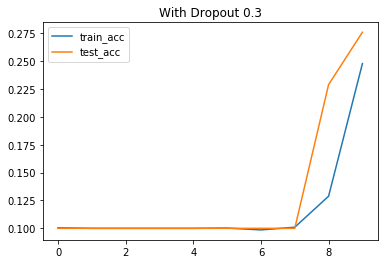

In [0]:
plt.plot(historyD3.history['acc']) 
plt.plot(historyD3.history['val_acc'])
plt.title('With Dropout 0.3')
plt.legend(['train_acc', 'test_acc'], loc='upper left')

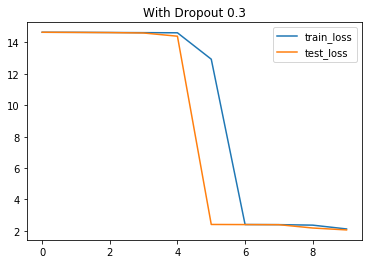

In [0]:
plt.plot(historyD3.history['loss']) 
plt.plot(historyD3.history['val_loss'])
plt.title('With Dropout 0.3')
plt.legend(['train_loss', 'test_loss'], loc='upper right')

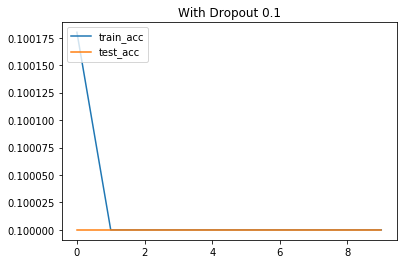

In [0]:
plt.plot(historyD1.history['acc']) 
plt.plot(historyD1.history['val_acc'])
plt.title('With Dropout 0.1')
plt.legend(['train_acc', 'test_acc'], loc='upper left')

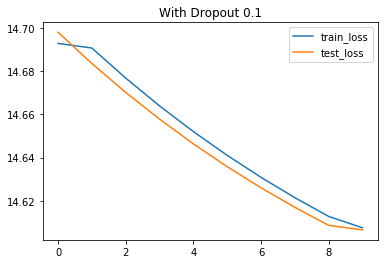

In [0]:
plt.plot(historyD1.history['loss']) 
plt.plot(historyD1.history['val_loss'])
plt.title('With Dropout 0.1')
plt.legend(['train_loss', 'test_loss'], loc='upper right')

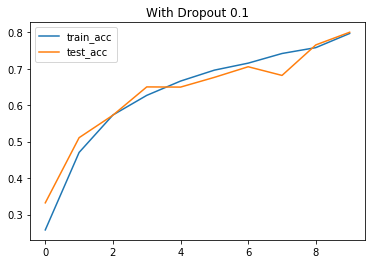

In [0]:
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc'])
plt.title('With Dropout 0.1')
plt.legend(['train_acc', 'test_acc'], loc='upper left')

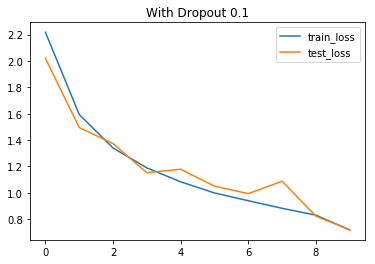

In [0]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.title('With Dropout 0.1')
plt.legend(['train_loss', 'test_loss'], loc='upper right')

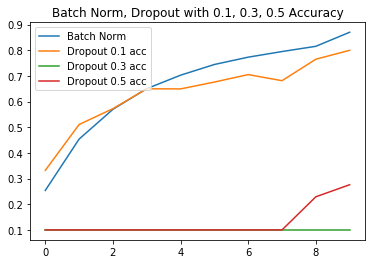

In [0]:
# plt.plot(history.history['loss']) 
plt.plot(historyBN.history['acc'])
plt.plot(history.history['val_acc'])
# plt.plot(historyD1.history['loss']) 
plt.plot(historyD1.history['val_acc'])
plt.plot(historyD3.history['val_acc'])
plt.title('Batch Norm, Dropout with 0.1, 0.3, 0.5 Accuracy')
plt.legend(['Batch Norm', 'Dropout 0.1 acc', 'Dropout 0.3 acc', 'Dropout 0.5 acc'], loc='upper left')

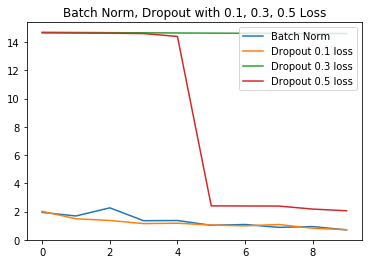

In [0]:
# plt.plot(history.history['loss']) 
plt.plot(historyBN.history['val_loss'])
plt.plot(history.history['val_loss'])
# plt.plot(historyD1.history['loss']) 
plt.plot(historyD1.history['val_loss'])
plt.plot(historyD3.history['val_loss'])
plt.title('Batch Norm, Dropout with 0.1, 0.3, 0.5 Loss')
plt.legend(['Batch Norm', 'Dropout 0.1 loss', 'Dropout 0.3 loss', 'Dropout 0.5 loss'], loc='upper right')

In [0]:
def lr_schedule1(epoch):
    initial_lrate = 0.0005
    drop = 0.25
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate
lrr = lr_schedule1(10)
# plt.plot(lrr)
print(lrr)

0.000125
